**Load the Preprocessed Dataset**

In [59]:
import numpy as np

# Load scaled features and labels
X_scaled = np.load('X_smote.npy')
y = np.load('y_smote.npy')

print("X_scaled shape:", X_scaled.shape)
print("y shape:", y.shape)


X_scaled shape: (4086, 11)
y shape: (4086,)


**Apply Feature Selection Methods.**

Method 1: Filter Method using Correlation

Feature Correlation with Quality:
 alcohol                 0.615332
sulphates               0.492793
citric acid             0.481394
fixed acidity           0.173340
free sulfur dioxide     0.074467
total sulfur dioxide    0.024764
residual sugar         -0.037288
chlorides              -0.294233
pH                     -0.309205
density                -0.329162
volatile acidity       -0.686029
Name: quality, dtype: float64


/tmp/ipython-input-3803420940.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation.values, y=correlation.index, palette='viridis')


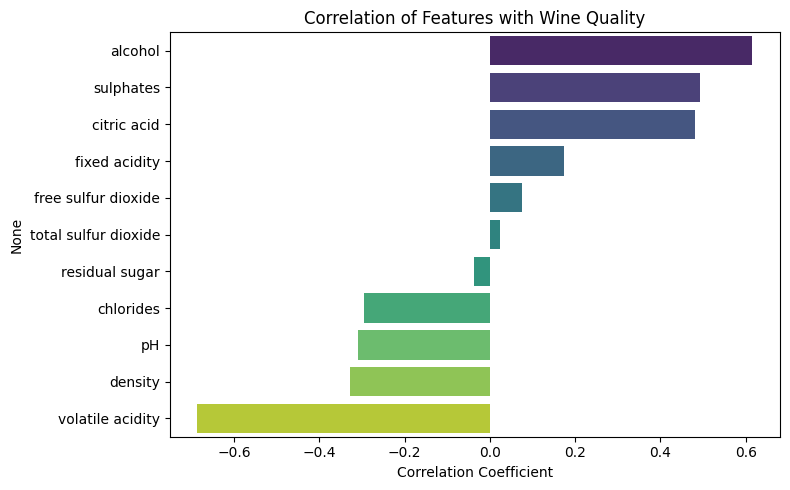

In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Rebuild a DataFrame so we know the column names
feature_names = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
                 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
                 'pH', 'sulphates', 'alcohol']
df_scaled = pd.DataFrame(X_scaled, columns=feature_names)
df_scaled['quality'] = y

# Calculate correlation with the target
correlation = df_scaled.corr(numeric_only=True)['quality'].drop('quality').sort_values(ascending=False)
print("Feature Correlation with Quality:\n", correlation)

# Plot correlation values
plt.figure(figsize=(8, 5))
sns.barplot(x=correlation.values, y=correlation.index, palette='viridis')
plt.title("Correlation of Features with Wine Quality")
plt.xlabel("Correlation Coefficient")
plt.tight_layout()
plt.savefig("correlation_with_quality.png")
plt.show()


In [61]:
# Threshold for selection
corr_threshold = 0.1

# Select features where abs(correlation) > threshold
selected_corr_features = correlation[correlation.abs() > corr_threshold].index.tolist()

# Output
print("Selected Features from Filter Method (Correlation > 0.1):")
print(selected_corr_features)


Selected Features from Filter Method (Correlation > 0.1):
['alcohol', 'sulphates', 'citric acid', 'fixed acidity', 'chlorides', 'pH', 'density', 'volatile acidity']


Method 2: Wrapper Method using RFE (Recursive Feature Elimination)

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

# Define model and RFE selector
model = RandomForestClassifier(random_state=42)
rfe = RFE(estimator=model, n_features_to_select=7)

# Fit RFE
rfe.fit(X_scaled, y)

# Get selected features
selected_rfe = [feature for feature, selected in zip(feature_names, rfe.support_) if selected]
print("Selected Features by RFE:", selected_rfe)


Selected Features by RFE: ['volatile acidity', 'citric acid', 'chlorides', 'total sulfur dioxide', 'density', 'sulphates', 'alcohol']


Method 3: Embedded Method using Random Forest Feature Importance

Top Features by Random Forest Importance:
                  Feature  Importance
10               alcohol    0.146595
1       volatile acidity    0.137220
9              sulphates    0.126834
4              chlorides    0.085880
2            citric acid    0.085292
6   total sulfur dioxide    0.084276
8                     pH    0.071824
0          fixed acidity    0.068560
7                density    0.066816
5    free sulfur dioxide    0.064586
3         residual sugar    0.062118


/tmp/ipython-input-2927939363.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='crest')


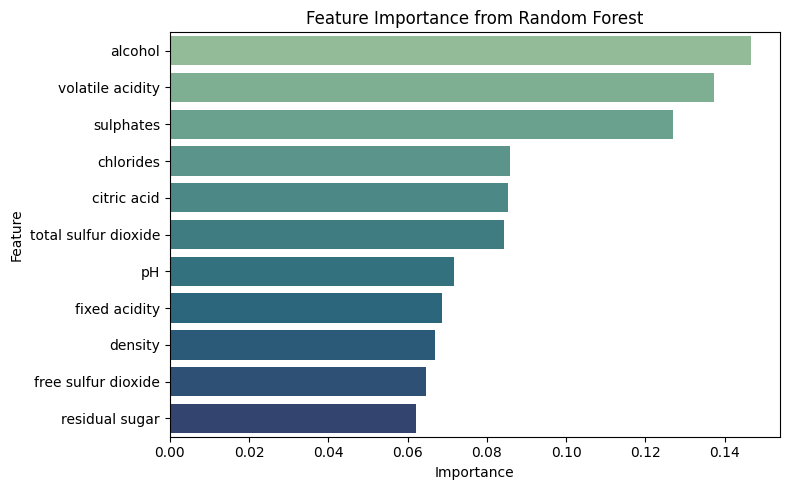

In [63]:
# Train a RandomForest model on all features
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_scaled, y)

# Get feature importances
importances = rf_model.feature_importances_

# Create DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Show top features
print("Top Features by Random Forest Importance:\n", importance_df)

# Plot feature importance
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='crest')
plt.title('Feature Importance from Random Forest')
plt.tight_layout()
plt.savefig("rf_feature_importance.png")
plt.show()


In [64]:
# Number of top features to select
top_n = 6

# Select top N important features
selected_rf_features = importance_df.head(top_n)['Feature'].tolist()

# Output
print("Selected Features from Embedded Method (Top 6 RF Importance):")
print(selected_rf_features)


Selected Features from Embedded Method (Top 6 RF Importance):
['alcohol', 'volatile acidity', 'sulphates', 'chlorides', 'citric acid', 'total sulfur dioxide']


**Model Training & Comparison**

Random Forest

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Split full feature set
X_train_all, X_test_all, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Prepare reduced feature sets
X_corr = df_scaled[selected_corr_features].values
X_rfe = df_scaled[selected_rfe].values
X_rf = df_scaled[selected_rf_features].values

# Train-test split for reduced sets
X_train_corr, X_test_corr = train_test_split(X_corr, test_size=0.2, random_state=42)
X_train_rfe, X_test_rfe = train_test_split(X_rfe, test_size=0.2, random_state=42)
X_train_rf, X_test_rf = train_test_split(X_rf, test_size=0.2, random_state=42)

# Function to train and evaluate
def evaluate_model(name, X_train, X_test, y_train, y_test):
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    print(f"\n{name} - Random Forest:")
    print(f"Accuracy:  {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall:    {rec:.3f}")
    print(f"F1 Score:  {f1:.3f}")
    return [name, acc, prec, rec, f1]

# Evaluate all
results = []
results.append(evaluate_model("All Features", X_train_all, X_test_all, y_train, y_test))
results.append(evaluate_model("Filter Method", X_train_corr, X_test_corr, y_train, y_test))
results.append(evaluate_model("RFE Method", X_train_rfe, X_test_rfe, y_train, y_test))
results.append(evaluate_model("RF Importance", X_train_rf, X_test_rf, y_train, y_test))



All Features - Random Forest:
Accuracy:  0.853
Precision: 0.853
Recall:    0.867
F1 Score:  0.856

Filter Method - Random Forest:
Accuracy:  0.836
Precision: 0.835
Recall:    0.851
F1 Score:  0.838

RFE Method - Random Forest:
Accuracy:  0.852
Precision: 0.853
Recall:    0.865
F1 Score:  0.852

RF Importance - Random Forest:
Accuracy:  0.840
Precision: 0.839
Recall:    0.851
F1 Score:  0.841


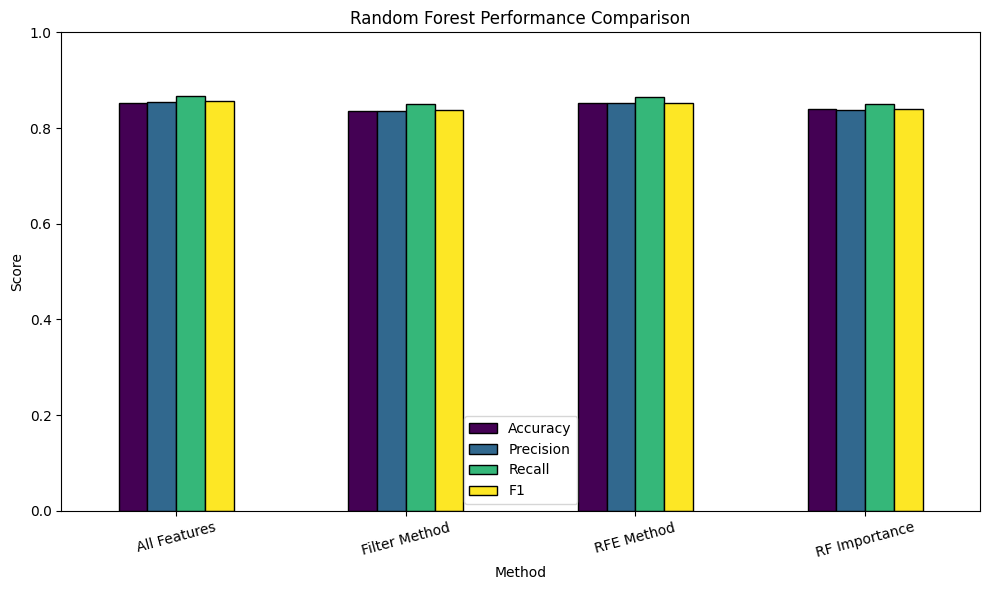

In [66]:
df_rf = pd.DataFrame(results, columns=["Method", "Accuracy", "Precision", "Recall", "F1"])
df_rf.set_index("Method").plot(kind='bar', figsize=(10,6), colormap='viridis', edgecolor='black')
plt.title("Random Forest Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig("random_forest_comparison.png")
plt.show()


Logistic Regression

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# Setup model
def train_logreg(X, y, name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    print(f"\n{name} - Logistic Regression")
    print(f"Accuracy:  {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall:    {rec:.3f}")
    print(f"F1 Score:  {f1:.3f}")
    return [name, acc, prec, rec, f1]

# Convert subsets
X_filter = df_scaled[selected_corr_features].values
X_rfe = df_scaled[selected_rfe].values
X_rf = df_scaled[selected_rf_features].values

# Run evaluation
results_logreg = []
results_logreg.append(train_logreg(X_scaled, y, "All Features"))
results_logreg.append(train_logreg(X_filter, y, "Filter Method"))
results_logreg.append(train_logreg(X_rfe, y, "RFE Method"))
results_logreg.append(train_logreg(X_rf, y, "RF Importance"))



All Features - Logistic Regression
Accuracy:  0.559
Precision: 0.542
Recall:    0.567
F1 Score:  0.546

Filter Method - Logistic Regression
Accuracy:  0.512
Precision: 0.495
Recall:    0.522
F1 Score:  0.502

RFE Method - Logistic Regression
Accuracy:  0.516
Precision: 0.504
Recall:    0.523
F1 Score:  0.506

RF Importance - Logistic Regression
Accuracy:  0.518
Precision: 0.505
Recall:    0.526
F1 Score:  0.508


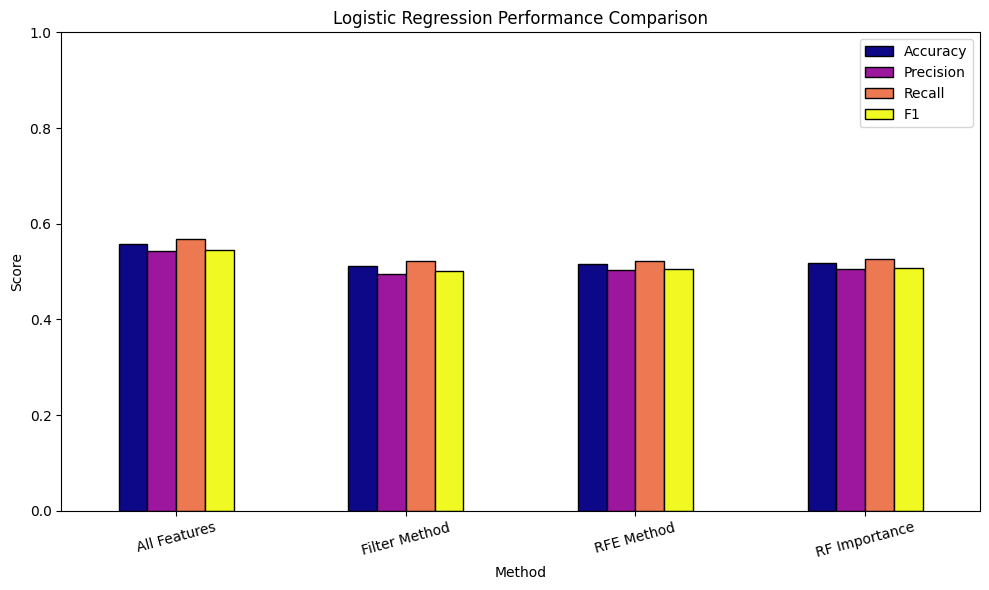

In [68]:
df_logreg = pd.DataFrame(results_logreg, columns=["Method", "Accuracy", "Precision", "Recall", "F1"])
df_logreg.set_index("Method").plot(kind='bar', figsize=(10,6), colormap='plasma', edgecolor='black')
plt.title("Logistic Regression Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig("logistic_regression_comparison.png")
plt.show()


In [69]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
import pandas as pd



Define Custom Scoring

In [70]:
scoring = {
    'accuracy': 'accuracy',
    'precision_macro': make_scorer(precision_score, average='macro', zero_division=0),
    'recall_macro': make_scorer(recall_score, average='macro', zero_division=0),
    'f1_macro': make_scorer(f1_score, average='macro', zero_division=0)
}


Cross-Validation Function

In [71]:
def evaluate_model_cv_verbose(model, X, y, model_name):
    scores = cross_validate(model, X, y, cv=5, scoring=scoring, return_train_score=False)

    print(f"\n📌 Cross-Validation Results for: {model_name}")
    print("-" * 55)
    for metric in ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']:
        values = scores[f'test_{metric}']
        mean = np.mean(values)
        std = np.std(values)

        print(f"{metric.capitalize():<18}: "
              f"Fold Scores = {np.round(values, 4)} | "
              f"Mean = {mean:.4f}, SD = {std:.4f}")
    print("-" * 55)

    return {
        "Model": model_name,
        "Accuracy": np.mean(scores['test_accuracy']),
        "Precision": np.mean(scores['test_precision_macro']),
        "Recall": np.mean(scores['test_recall_macro']),
        "F1": np.mean(scores['test_f1_macro'])
    }

In [75]:
evaluate_model_cv_verbose(RandomForestClassifier(), X_scaled, y, "Random Forest - All Features")



📌 Cross-Validation Results for: Random Forest - All Features
-------------------------------------------------------
Accuracy          : Fold Scores = [0.846  0.8127 0.7931 0.8397 0.8262] | Mean = 0.8235, SD = 0.0190
Precision_macro   : Fold Scores = [0.8496 0.7999 0.7768 0.8296 0.82  ] | Mean = 0.8152, SD = 0.0250
Recall_macro      : Fold Scores = [0.8458 0.8132 0.793  0.8395 0.826 ] | Mean = 0.8235, SD = 0.0190
F1_macro          : Fold Scores = [0.8305 0.8017 0.7762 0.8305 0.8155] | Mean = 0.8109, SD = 0.0204
-------------------------------------------------------


{'Model': 'Random Forest - All Features',
 'Accuracy': np.float64(0.823538319272908),
 'Precision': np.float64(0.815186556040248),
 'Recall': np.float64(0.823484685845141),
 'F1': np.float64(0.8108848662701004)}

In [76]:
evaluate_model_cv_verbose(LogisticRegression(), X_scaled, y, "Logistic Regression - All Features")



📌 Cross-Validation Results for: Logistic Regression - All Features
-------------------------------------------------------
Accuracy          : Fold Scores = [0.5795 0.5459 0.5557 0.5398 0.5373] | Mean = 0.5516, SD = 0.0153
Precision_macro   : Fold Scores = [0.5538 0.5163 0.5331 0.5232 0.5216] | Mean = 0.5296, SD = 0.0133
Recall_macro      : Fold Scores = [0.579  0.5464 0.5559 0.5399 0.537 ] | Mean = 0.5516, SD = 0.0151
F1_macro          : Fold Scores = [0.5524 0.5246 0.5334 0.5263 0.5229] | Mean = 0.5319, SD = 0.0109
-------------------------------------------------------


{'Model': 'Logistic Regression - All Features',
 'Accuracy': np.float64(0.5516329346137846),
 'Precision': np.float64(0.5295979388509582),
 'Recall': np.float64(0.5516333905825104),
 'F1': np.float64(0.5319153035045939)}

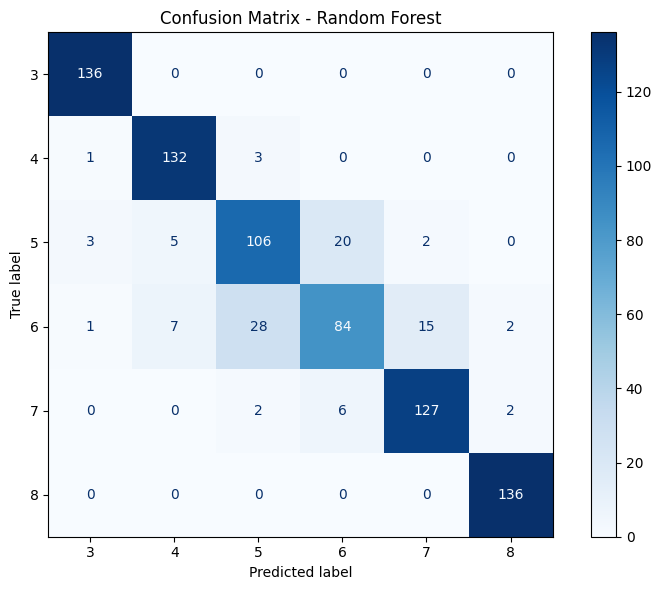

In [77]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# === Use your full feature set and preprocessed data ===
# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Train Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# === Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Random Forest")
plt.grid(False)
plt.tight_layout()
plt.show()


**Hyperparameter Tuning**

In [78]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score


In [79]:
# Load the SMOTE-balanced dataset saved in Lab 3
X_smote = np.load("X_smote.npy")
y_smote = np.load("y_smote.npy")

print("Balanced dataset shape:", X_smote.shape, y_smote.shape)


Balanced dataset shape: (4086, 11) (4086,)


In [80]:
scoring = {
    'accuracy': 'accuracy',
    'precision_macro': make_scorer(precision_score, average='macro', zero_division=0),
    'recall_macro': make_scorer(recall_score, average='macro', zero_division=0),
    'f1_macro': make_scorer(f1_score, average='macro', zero_division=0)
}


Define parameter grid

In [81]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}


In [82]:
# Define model
rf = RandomForestClassifier(random_state=42, class_weight="balanced")

# Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=scoring,
    refit='f1_macro',   # choose F1 as the main metric
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Fit grid search
grid_search.fit(X_smote, y_smote)

# Best parameters
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score (CV):", grid_search.best_score_)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Best F1 Score (CV): 0.8063404401800651


In [83]:
# Convert CV results into a DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Save as CSV for analysis
results_df.to_csv("rf_gridsearch_results.csv", index=False)

# Show top 5 configs
results_df.sort_values(by="mean_test_f1_macro", ascending=False).head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_accuracy,split1_test_accuracy,...,std_test_recall_macro,rank_test_recall_macro,split0_test_f1_macro,split1_test_f1_macro,split2_test_f1_macro,split3_test_f1_macro,split4_test_f1_macro,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro
23,4.504837,0.511751,0.081636,0.035040,20,5,200,"{'max_depth': 20, 'min_samples_split': 5, 'n_e...",0.843521,0.801714,...,0.019319,1,0.831514,0.792292,0.774607,0.821884,0.811406,0.806340,0.020520,1
4,2.049288,0.019607,0.039413,0.002969,None,5,100,"{'max_depth': None, 'min_samples_split': 5, 'n...",0.828851,0.796818,...,0.014625,3,0.816221,0.788471,0.784649,0.819881,0.816536,0.805151,0.015282,2
22,2.598512,0.451316,0.050699,0.016086,20,5,100,"{'max_depth': 20, 'min_samples_split': 5, 'n_e...",0.836186,0.794370,...,0.017481,6,0.824472,0.785861,0.780977,0.816077,0.818051,0.805088,0.017976,3
5,4.855997,0.691768,0.084419,0.037910,None,5,200,"{'max_depth': None, 'min_samples_split': 5, 'n...",0.841076,0.796818,...,0.020176,5,0.828326,0.786504,0.772061,0.819285,0.814998,0.804235,0.021318,4
18,1.636977,0.394940,0.037263,0.009283,20,2,50,"{'max_depth': 20, 'min_samples_split': 2, 'n_e...",0.834963,0.790698,...,0.017257,7,0.821070,0.781357,0.793985,0.825651,0.798759,0.804164,0.016736,5


from matplotlib import pyplot as plt
_df_0['mean_fit_time'].plot(kind='hist', bins=20, title='mean_fit_time')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['std_fit_time'].plot(kind='hist', bins=20, title='std_fit_time')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['mean_score_time'].plot(kind='hist', bins=20, title='mean_score_time')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['std_score_time'].plot(kind='hist', bins=20, title='std_score_time')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('param_max_depth').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='mean_fit_time', y='std_fit_time', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='std_fit_time', y='mean_score_time', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='mean_score_time', y='std_score_time', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='std_score_time', y='param_min_samples_split', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['mean_fit_time']
  ys = series['param_min_samples_split']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('mean_fit_time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('param_max_depth')):
  _plot_series(series, series_name, i)
  fig.legend(title='param_max_depth', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('mean_fit_time')
_ = plt.ylabel('param_min_samples_split')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['mean_fit_time']
  ys = series['param_n_estimators']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('mean_fit_time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('param_max_depth')):
  _plot_series(series, series_name, i)
  fig.legend(title='param_max_depth', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('mean_fit_time')
_ = plt.ylabel('param_n_estimators')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['mean_fit_time']
  ys = series['split0_test_accuracy']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('mean_fit_time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('param_max_depth')):
  _plot_series(series, series_name, i)
  fig.legend(title='param_max_depth', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('mean_fit_time')
_ = plt.ylabel('split0_test_accuracy')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['mean_fit_time']
  ys = series['split1_test_accuracy']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('mean_fit_time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('param_max_depth')):
  _plot_series(series, series_name, i)
  fig.legend(title='param_max_depth', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('mean_fit_time')
_ = plt.ylabel('split1_test_accuracy')

from matplotlib import pyplot as plt
_df_13['mean_fit_time'].plot(kind='line', figsize=(8, 4), title='mean_fit_time')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['std_fit_time'].plot(kind='line', figsize=(8, 4), title='std_fit_time')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['mean_score_time'].plot(kind='line', figsize=(8, 4), title='mean_score_time')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_16['std_score_time'].plot(kind='line', figsize=(8, 4), title='std_score_time')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['param_max_depth'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='mean_fit_time', y='param_max_depth', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_18['param_max_depth'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_18, x='std_fit_time', y='param_max_depth', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['param_max_depth'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='mean_score_time', y='param_max_depth', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['param_max_depth'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='std_score_time', y='param_max_depth', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

Final Model & Validation

Final Model Performance on Test Set:

              precision    recall  f1-score   support

           3      0.951     1.000     0.975       136
           4      0.916     0.963     0.939       136
           5      0.798     0.757     0.777       136
           6      0.763     0.635     0.693       137
           7      0.854     0.942     0.896       137
           8      0.986     1.000     0.993       136

    accuracy                          0.883       818
   macro avg      0.878     0.883     0.879       818
weighted avg      0.878     0.883     0.879       818



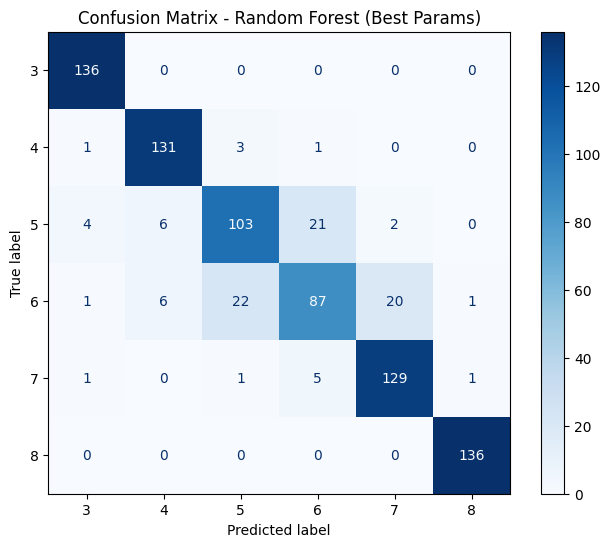

In [84]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Train-test split (80/20) on SMOTE dataset
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42, stratify=y_smote)

# Train best RF model
best_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    class_weight="balanced",
    random_state=42
)

best_rf.fit(X_train, y_train)

# Predict
y_pred = best_rf.predict(X_test)

# Classification report
print("Final Model Performance on Test Set:\n")
print(classification_report(y_test, y_pred, digits=3))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_smote))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_smote))

fig, ax = plt.subplots(figsize=(8,6))
disp.plot(ax=ax, cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Random Forest (Best Params)")
plt.show()
